# Forecasting Shrimp Price (Mexico) - Data From US Department of Commerce
## Context

Description: Shrimp , (Mexico), west coast, frozen, white, No. 1, shell-on, headless, 26 to 30 count per pound, wholesale price at New York.
Content

Top commodity suppliers.
Acknowledgements

https://www.indexmundi.com/commodities/?commodity=shrimp&months=120
Source: US Department of Commerce, NOAA, Fishery Market News; World Bank.
Inspiration

Agricultural production statistics.

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta

In [144]:
df = pd.read_csv('shrimp-prices.csv',parse_dates=['Month'],index_col = 'Month')
df = df['Price']

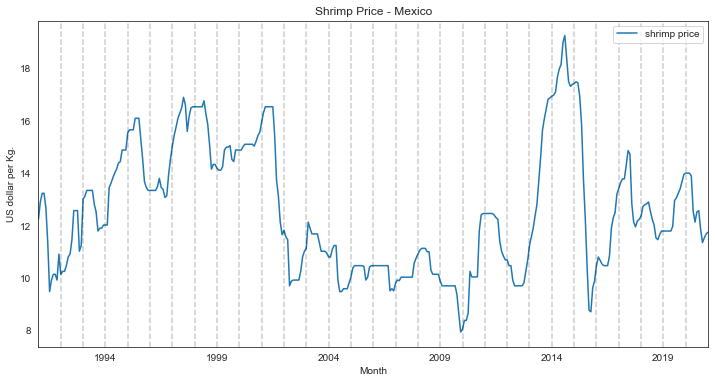

In [145]:
start_year = df.index[0].year
end_year = df.index[-1].year
plt.figure(figsize=(12,6))
sns.set_style('white')
df.plot(label='shrimp price')
for year in range(start_year,end_year):
    plt.axvline(pd.to_datetime(str(year)),linestyle='--',color='k',alpha=0.2)
plt.title('Shrimp Price - Mexico')
plt.ylabel('US dollar per Kg.')
plt.legend()
plt.show()

consider time series from 2002

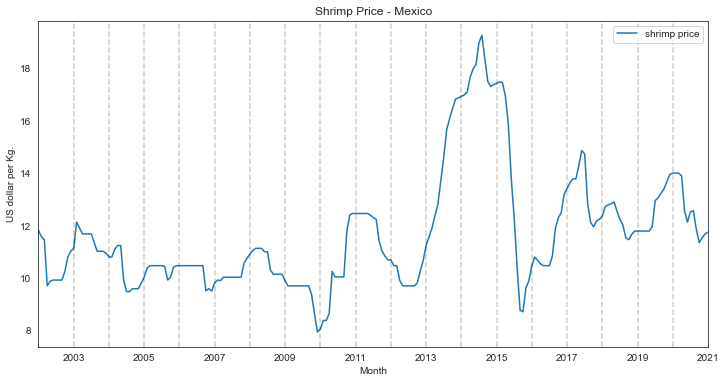

In [146]:
ts = df["2002":] 
start_year = ts.index[0].year
end_year = ts.index[-1].year

# plot data from 2002 to 2021
plt.figure(figsize=(12,6))
sns.set_style('white')
ts.plot(label='shrimp price')
for year in range(start_year,end_year):
    plt.axvline(pd.to_datetime(str(year)),linestyle='--',color='k',alpha=0.2)
plt.title('Shrimp Price - Mexico')
plt.ylabel('US dollar per Kg.')
plt.legend()
plt.show()

## split train set and validation set

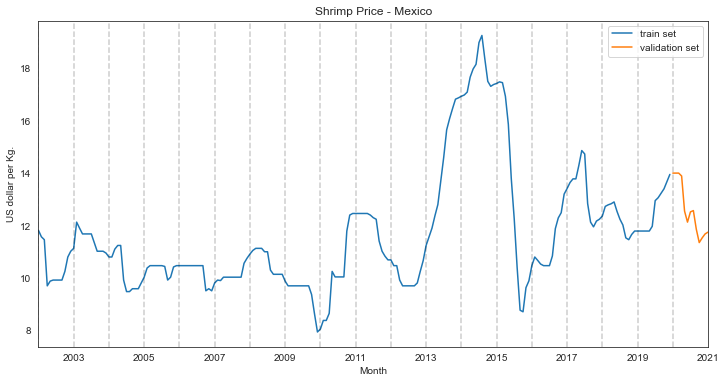

In [295]:
train_ts = ts['2002':'2019'] 
val_ts = ts['2020':]

# plot data from 2002 to 2021
plt.figure(figsize=(12,6))
sns.set_style('white')
train_ts.plot(label='train set')
val_ts.plot(label='validation set')
for year in range(start_year,end_year):
    plt.axvline(pd.to_datetime(str(year)),linestyle='--',color='k',alpha=0.2)
plt.title('Shrimp Price - Mexico')
plt.ylabel('US dollar per Kg.')
plt.legend()
plt.show()

In [148]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

In [149]:
def plot_acf_pacf(ts):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(ts,lags=40,ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(ts,lags=40, ax=ax2)
    plt.show()

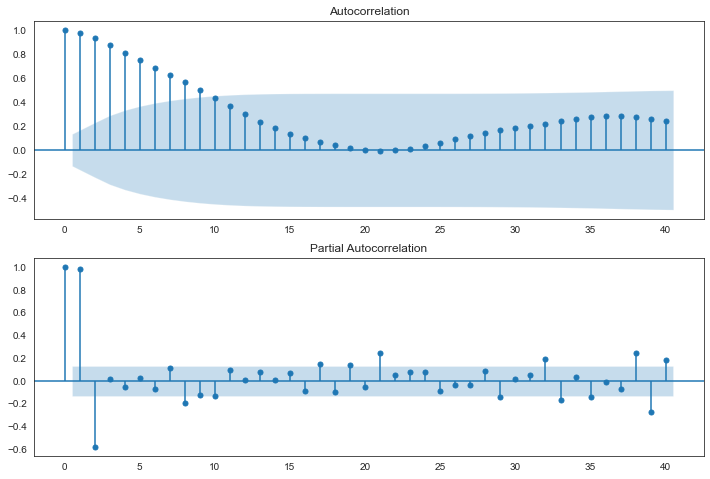

In [150]:
plot_acf_pacf(train_ts)

not stationary because acf exponentially decays

In [151]:
def adfuller_test(ts):
    result = adfuller(ts)
    labels = ['ADF test Statistics','p-value','#Lags used', 'Number of Observation Used']
    for value,label in zip(result,labels):
        print(label,':',value)
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis(H0), reject the null hypothesis. Data has no unit root and is stationary')
    else:
        print('weak evidence against the null hypothesis, fail to reject H0. time series has a unit root, indicating it is not stationary')

In [152]:
adfuller_test(train_ts)

ADF test Statistics : -2.6212116249076116
p-value : 0.08869202170223534
#Lags used : 1
Number of Observation Used : 214
weak evidence against the null hypothesis, fail to reject H0. time series has a unit root, indicating it is not stationary


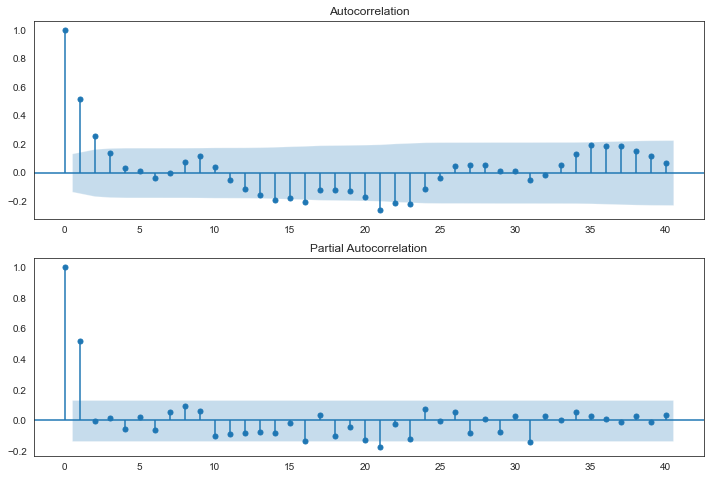

In [153]:
train_ts_diff = train_ts.diff()[1:]
plot_acf_pacf(train_ts_diff)

In [154]:
adfuller_test(train_ts_diff)

ADF test Statistics : -8.257543759325428
p-value : 5.188089292490526e-13
#Lags used : 0
Number of Observation Used : 214
Strong evidence against the null hypothesis(H0), reject the null hypothesis. Data has no unit root and is stationary


- train_ts_diff is a stationary
- Select base model ARIMA(1,1,0)

In [253]:
ARIMA110 = ARIMA(train_ts,order=(1,1,0))
ARIMA110_fit = ARIMA110.fit(disp=0)
print(ARIMA110_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Price   No. Observations:                  215
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -115.797
Method:                       css-mle   S.D. of innovations              0.414
Date:                Sun, 09 Jan 2022   AIC                            237.593
Time:                        15:53:01   BIC                            247.705
Sample:                    02-01-2002   HQIC                           241.679
                         - 12-01-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0099      0.058      0.172      0.863      -0.103       0.123
ar.L1.D.Price     0.5116      0.058      8.763      0.000       0.397       0.626
                                    Root

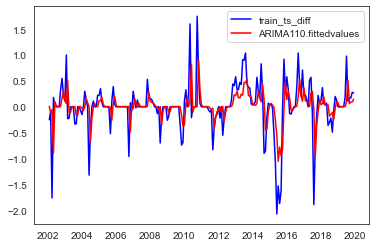

In [254]:
plt.plot(train_ts_diff,color='blue',label='train_ts_diff')
plt.plot(ARIMA110_fit.fittedvalues,color='red',label='ARIMA110.fittedvalues')
plt.legend()
plt.show()

In [277]:
predictions_ARIMA_diff = pd.Series(ARIMA110_fit.predict(start= 1,end=215),copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff.head())
print(predictions_ARIMA_diff.tail())
print(predictions_ARIMA_diff_cumsum.head())
print(predictions_ARIMA_diff_cumsum.tail())

2002-02-01    0.009908
2002-03-01   -0.123055
2002-04-01   -0.051434
2002-05-01   -0.895538
2002-06-01    0.096923
Freq: MS, dtype: float64
2019-08-01    0.506185
2019-09-01    0.061113
2019-10-01    0.091807
2019-11-01    0.091807
2019-12-01    0.148081
Freq: MS, dtype: float64
2002-02-01    0.009908
2002-03-01   -0.113147
2002-04-01   -0.164582
2002-05-01   -1.060119
2002-06-01   -0.963196
Freq: MS, dtype: float64
2019-08-01    1.604228
2019-09-01    1.665341
2019-10-01    1.757149
2019-11-01    1.848956
2019-12-01    1.997037
Freq: MS, dtype: float64


In [278]:
predictions_ARIMA = pd.Series(train_ts.iloc[0], index=train_ts.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA

2002-01-01    11.820000
2002-02-01    11.829908
2002-03-01    11.706853
2002-04-01    11.655418
2002-05-01    10.759881
                ...    
2019-08-01    13.424228
2019-09-01    13.485341
2019-10-01    13.577149
2019-11-01    13.668956
2019-12-01    13.817037
Length: 216, dtype: float64

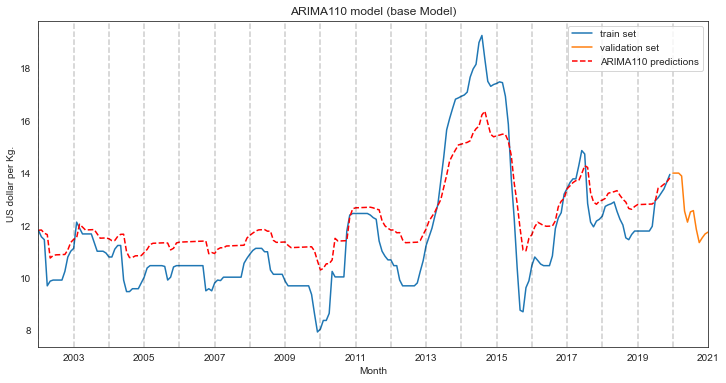

In [319]:
plt.figure(figsize=(12,6))
sns.set_style('white')
train_ts.plot(label='train set')
val_ts.plot(label='validation set')
predictions_ARIMA.plot(label='ARIMA110 predictions',color='red',linestyle='--')
for year in range(start_year,end_year):
    plt.axvline(pd.to_datetime(str(year)),linestyle='--',color='k',alpha=0.2)

plt.title('ARIMA110 model (base Model)')
plt.ylabel('US dollar per Kg.')
plt.legend()
plt.show()

### Extraploation Forecast 2020-2021

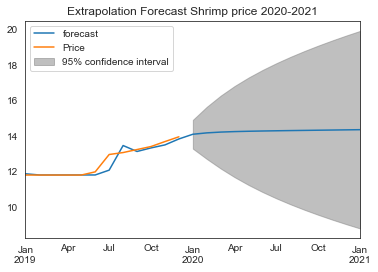

In [321]:
fig = ARIMA110_fit.plot_predict('2019','2021')
plt.legend(loc='upper left')
plt.title('Extrapolation Forecast Shrimp price 2020-2021')
ax = plt.plot(val_ts)
plt.show()